### Build the Fossil Identification model

This script processes the labeled images of fossil specimens and uses them to train a Convolutional Neural Network (CNN) that can take (as input) an image of a fossil, then give (as output) the scientific name of that fossil.

### Imports

In [13]:
import image_helpers as ih
import os
import datetime
import pickle
import shutil
from pathlib import Path
from PIL import Image, ImageOps
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
from tensorflow.keras.applications.efficientnet import EfficientNetB1
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
%matplotlib inline


### Preprocessing: Resize all input images

The EfficientNetB1 model expects 224x224 images.  It will stretch/squeeze the images into that size.  This introduces distortions that make the classification task less accurate.

To avoid those distortions, we will resize the images to the necessary 224x224 size while maintaining their aspect ratio.

In [14]:
# Create a temporary copy of the image data directory
ih.createTemporaryDirectory('../image_data')

# Iterate through all the files in the temp directory, opening them, resizing them
# (while maintaining their aspect ratio), and then saving those resized images
ih.resizeImagesInDirectory('../temp_image_data')

# Set the data_dir to point to temp_image_data
data_dir = '../temp_image_data'

# Note: This temp_ directory will be removed at the end of this script 
# as a clean-up operation.


### Set the input_shape and batch_size

In [15]:
# EfficientNetB1 expects (224, 224)
input_shape = (224,224)

# Set the batch size to around 1/4 of the number of input files
folder_names = [name for name in os.listdir(data_dir) if not name.startswith(".")]
num_files = 0
for n in folder_names:
    num_files += len([name for name in os.listdir(data_dir + '/' + n) if not name.startswith(".")])
batch_size = num_files // 4 + 1


### Create training and validation set generators

In [16]:
train_datagen = ImageDataGenerator(
    rescale          = 1.0/255.0,
    zoom_range       = 0.2,
    rotation_range   = 5,
    horizontal_flip  = True,
    vertical_flip    = True,
    validation_split = 0.20
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size = input_shape,
    batch_size  = batch_size,
    class_mode  = 'categorical',
    subset      = 'training'
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size = input_shape,
    batch_size  = batch_size,
    class_mode  = 'categorical',
    subset      = 'validation'
)


Found 59 images belonging to 5 classes.
Found 12 images belonging to 5 classes.


### Save the labels for each class

The labels (i.e., scientific names of each fossil in the training and validation dataset) are saved to a simple text file.  This "mapping" can then be passed on to any script that uses the trained model, so its outputs can be translated to actual fossil names.

In [17]:
# Extract the class names from train_generator
label_map = sorted(train_generator.class_indices)

# Save these labels into a file that can be opened
# by any script that uses the trained model
with open("../model/labels.txt", "wb") as pf:
    pickle.dump(label_map, pf)


### Create an EfficientNetB1 model to use as a base for transfer learning

In [18]:
EffNetB1 = EfficientNetB1(
    weights = 'imagenet', 
    include_top = False
)

### Use GlobalAveragePooling

The EfficientNetB7 output features are high-density.  Here we reduce that by averaging the values across each dimension.  By using averages rather than the actual values, we can speed up training and reduce the possibility of overfitting.

In [ ]:
GAP_output = GlobalAveragePooling2D()(EffNetB1.output)


### Create a dense layer to represent the predictions

In [ ]:
predictions = Dense(
    len(train_generator.class_indices), 
    activation='softmax'
)(GAP_output)


### Complete the model definition

In [19]:
model = Model(
    inputs  = EffNetB1.input,
    outputs = predictions
)


### Compile the model

In [20]:
model.compile(
    optimizer = 'adam',
    loss      = 'categorical_crossentropy',
    metrics   =  ['acc']
)
#model.summary()


### Define callback functions

In [21]:
# EarlyStopping will force the model to stop training once it has stopped improving 
# significantly for a given number of epochs.
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, min_delta=0.0001)

# ModelCheckpoint will instruct the training process to keep a running copy of 
# the best model achieved as it progresses
now = datetime.datetime.now()
mc = ModelCheckpoint('../model/best_model_checkpoint_' + now.strftime("%Y-%m-%d-%H-%M") + '.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')


### Train the model

In [22]:
history = model.fit(
    x                = train_generator,
    callbacks        = [es, mc],
    validation_data  = validation_generator,
    steps_per_epoch  = train_generator.samples // batch_size + 1,
    validation_steps = validation_generator.samples // batch_size + 1,
    workers          = 8,
    max_queue_size   = 16,
    epochs           = 200,
    verbose          = 1
)


Epoch 1/200
4/4 [==============================] - 38s 8s/step - loss: 1.4618 - acc: 0.2851 - val_loss: 1.7138 - val_acc: 0.0833

Epoch 00001: val_acc improved from -inf to 0.08333, saving model to ../model/best_model_checkpoint_2021-02-15-17-23.hdf5
Epoch 2/200
4/4 [==============================] - 23s 5s/step - loss: 0.5637 - acc: 0.9021 - val_loss: 1.8133 - val_acc: 0.0833

Epoch 00002: val_acc did not improve from 0.08333
Epoch 3/200
4/4 [==============================] - 20s 5s/step - loss: 0.1614 - acc: 0.9545 - val_loss: 1.8833 - val_acc: 0.0000e+00

Epoch 00003: val_acc did not improve from 0.08333
Epoch 4/200
4/4 [==============================] - 20s 5s/step - loss: 0.0899 - acc: 0.9932 - val_loss: 1.9941 - val_acc: 0.0000e+00

Epoch 00004: val_acc did not improve from 0.08333
Epoch 5/200
4/4 [==============================] - 20s 5s/step - loss: 0.3325 - acc: 0.9068 - val_loss: 2.1969 - val_acc: 0.0000e+00

Epoch 00005: val_acc did not improve from 0.08333
Epoch 6/200
4/4 [

4/4 [==============================] - 29s 6s/step - loss: 0.0386 - acc: 1.0000 - val_loss: 2.2959 - val_acc: 0.0000e+00

Epoch 00045: val_acc did not improve from 0.33333
Epoch 46/200
4/4 [==============================] - 29s 6s/step - loss: 0.0399 - acc: 0.9883 - val_loss: 1.8532 - val_acc: 0.0000e+00

Epoch 00046: val_acc did not improve from 0.33333
Epoch 47/200
4/4 [==============================] - 28s 9s/step - loss: 0.9243 - acc: 0.8356 - val_loss: 2.3301 - val_acc: 0.0000e+00

Epoch 00047: val_acc did not improve from 0.33333
Epoch 48/200
4/4 [==============================] - 25s 6s/step - loss: 0.1969 - acc: 0.9452 - val_loss: 3.9341 - val_acc: 0.0000e+00

Epoch 00048: val_acc did not improve from 0.33333
Epoch 49/200
4/4 [==============================] - 22s 5s/step - loss: 0.0410 - acc: 1.0000 - val_loss: 5.7944 - val_acc: 0.0000e+00

Epoch 00049: val_acc did not improve from 0.33333
Epoch 50/200
4/4 [==============================] - 20s 6s/step - loss: 0.2323 - acc: 0.

### Display the Accuracy and Loss statistics

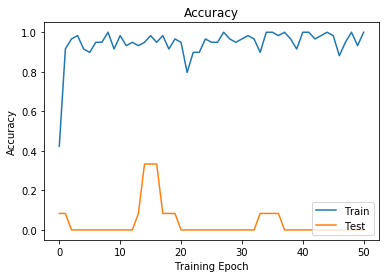

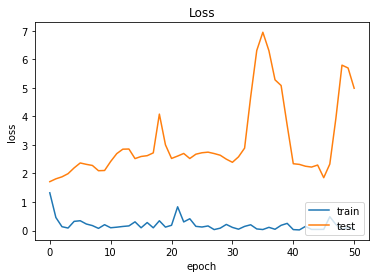

In [23]:
# Accuracy statistics
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Training Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

# Loss statistics
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()


### Clean up the temp_image_data folder

In [24]:
ih.removeTemporaryDirectory('../temp_image_data')
